In [302]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sta457-project-data/SP 500 Historical Data.csv
/kaggle/input/sta457-project-data/final_df1.csv
/kaggle/input/sta457-project-data/Cushing_OK_WTI_Spot_Price_FOB.csv
/kaggle/input/sta457-project-data/Daily Prices_ICCO.csv
/kaggle/input/sta457-project-data/SP 500 Historical Data 2.csv
/kaggle/input/sta457-project-data/Confectionery Product Manufacturing.csv


In [303]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchinfo import summary
from torch import GradScaler, autocast

import statsmodels.api as sm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split

import random
import os
import albumentations
from tqdm import tqdm
from datetime import datetime
import pytz
from copy import deepcopy
import gc

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

print("imports done")

imports done


In [304]:
def get_torch_version():
    torch_version = torch.__version__.split("+")[0]
    torch_number = torch_version.split(".")[:2]
    torch_number_float = torch_number[0] + "." + torch_number[1]
    torch_number_float = float(torch_number_float)
    return torch_number_float


def set_seed(seed=42):
    """
    Seeds basic parameters for reproducibility of results
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        # if get_torch_version() <= 1.7:
        #     torch.set_deterministic(True)
        # else:
        #     torch.use_deterministic_algorithms(True)
    print(f"seed {seed} set!")


def set_scheduler(scheduler, results, scheduler_on):
    """Makes the neccessary updates to the scheduler."""
    if scheduler_on == "valid_loss(mse)":
        scheduler.step(results["valid_loss(mse)"][-1])
    elif scheduler_on == "train_loss(mse)":
        scheduler.step(results["train_loss(mse)"][-1])
    else:
        raise ValueError("Invalid `scheduler_on` choice.")
    return scheduler


def visualize_results(results, plot_name=None):
    """Plot the training and validation loss and accuracy, given the results dictionary""" 
    x = np.arange(len(results["train_loss(mse)"]))  # this is the number of epochs
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
    ax[0,0].set_title("Loss")
    # ax[0,0].set_xlabel("Epochs")
    # ax[0,0].set_ylabel("Loss")
    ax[0,0].plot(x, results["train_loss(mse)"], label="train_loss(mse)", color="orange")
    ax[0,0].plot(x, results["valid_loss(mse)"], label="valid_loss(mse)", color="blue")
    ax[0,0].plot(x, results["train_rmse"], label="train_rmse", color="green")
    ax[0,0].plot(x, results["valid_rmse"], label="valid_rmse", color="red")
    ax[0,0].legend()
    ax[0,1].set_title("RMSLE")
    # ax[0,1].set_xlabel("Epochs")
    # ax[0,1].set_ylabel("RMSLE")
    ax[0,1].plot(x, results["train_rmsle"], label="train_rmsle", color="orange")
    ax[0,1].plot(x, results["valid_rmsle"], label="valid_rmsle", color="blue")
    ax[0,1].legend()
    ax[1,0].set_title("MAPE")
    ax[1,0].set_xlabel("Epochs")
    # ax[1,0].set_ylabel("MAPE")
    ax[1,0].plot(x, results["train_mape"], label="train_mape", color="orange")
    ax[1,0].plot(x, results["valid_mape"], label="valid_mape", color="blue")
    ax[1,0].legend()
    ax[1,1].set_title(r"$\mathbf{R^2}$")
    ax[1,1].set_xlabel("Epochs")
    # ax[1,1].set_ylabel(r"$\mathbf{R^2}$")
    ax[1,1].plot(x, results["train_r2"], label="train_r2", color="orange")
    ax[1,1].plot(x, results["valid_r2"], label="valid_r2", color="blue")
    ax[1,1].legend()
    if plot_name is not None:
        plt.savefig(plot_name)
    plt.show()
    

def train_step(model, loss_fn, optimizer, dataloader, device, scaler=None):
    model.train()
    train_loss = 0
    all_labels = []
    all_preds = []
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        if scaler is not None:           # do automatic mixed precision training
            with autocast(device):       # mixed precision forward pass
                logit = model(X)
                # note: first put logit and then y in the loss_fn
                # otherwise, if you put y first and then logit, then it will raise an error
                loss = loss_fn(logit, y)
            scaler.scale(loss).backward()      # mixed precision backward pass
            scaler.step(optimizer)             # updating optimizer
            scaler.update()                    # updating weights
        else:                     # don't do any mixed precision training
            logit = model(X)
            loss = loss_fn(logit, y)
            loss.backward()
            optimizer.step()
        all_labels.extend(y.detach().cpu().numpy())
        all_preds.extend(logit.detach().cpu().numpy())
        train_loss += loss.item()
    train_loss = train_loss / len(dataloader)
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    return train_loss, all_labels, all_preds
        

def valid_step(model, loss_fn, dataloader, device):
    model.eval()
    valid_loss = 0
    all_labels = []
    all_preds = []
    with torch.inference_mode():
        for X, y in dataloader:
            X = X.to(device)
            logit = model(X)
            loss = loss_fn(logit, y)
            all_labels.extend(y.detach().cpu().numpy())
            all_preds.extend(logit.detach().cpu().numpy())
            valid_loss += loss.item()
    valid_loss = valid_loss / len(dataloader)
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    return valid_loss, all_labels, all_preds


def training_fn1(model, loss_fn, optimizer, train_dataloader, valid_dataloader, device, 
                 epochs, scheduler=None, scheduler_on="valid_loss(mse)", verbose=False, scaler=None,
                 save_best_model=False, path=None, model_name=None, optimizer_name=None, 
                 scheduler_name=None):
    """
    Does model training and validation for one fold in a k-fold cross validation setting.
    """
    results = {
        "train_loss(mse)": [],
        "valid_loss(mse)": [],
        "train_rmse": [],
        "valid_rmse": [],
        "train_rmsle": [],
        "valid_rmsle": [],
        "train_mape": [],
        "valid_mape": [],
        "train_r2": [],
        "valid_r2": [],
    }
    best_val_loss = float('inf')
    for epoch in tqdm(range(epochs)):
        train_loss, train_labels, train_preds = train_step(model, loss_fn, optimizer, 
                                                           train_dataloader, device, scaler)
        valid_loss, valid_labels, valid_preds = valid_step(model, loss_fn, valid_dataloader, 
                                                           device)
        results["train_loss(mse)"].append(train_loss)
        results["valid_loss(mse)"].append(valid_loss)
        results["train_rmse"].append(mean_squared_error(train_preds, train_labels, squared=False))
        results["valid_rmse"].append(mean_squared_error(valid_preds, valid_labels, squared=False))
        results["train_rmsle"].append(mean_squared_log_error(train_preds+1, train_labels+1, squared=False))
        results["valid_rmsle"].append(mean_squared_log_error(valid_preds+1, valid_labels+1, squared=False))
        results["train_mape"].append(mean_absolute_percentage_error(train_preds, train_labels))
        results["valid_mape"].append(mean_absolute_percentage_error(valid_preds, valid_labels))
        results["train_r2"].append(r2_score(train_preds, train_labels))
        results["valid_r2"].append(r2_score(valid_preds, valid_labels))
        if verbose:
            print(
                    f"Epoch: {epoch+1} | Train_loss(mse): {train_loss:.5f} | "
                    f"Val_loss(mse): {valid_loss:.5f} | "
                )
        
        if scheduler is not None:
            scheduler = set_scheduler(scheduler, results, scheduler_on)
            if valid_loss < best_val_loss:
                best_val_loss = valid_loss
                plot_name = path + "/" + model_name[:-3] + "_" + optimizer_name[:-3] + "_" + scheduler_name[:-3] + ".pdf"
                save_model_info(path, device, model, model_name, optimizer, optimizer_name, 
                                scheduler, scheduler_name)
        else:
            if valid_loss < best_val_loss:
                best_val_loss = valid_loss
                plot_name = path + "/" + model_name[:-3] + "_" + optimizer_name[:-3] + ".pdf"
                save_model_info(path, device, model, model_name, optimizer, optimizer_name) 
    visualize_results(results, plot_name)


def save_model_info(path: str, device, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    model.to(device)
    torch.save(model.state_dict(), os.path.join(path,model_name))
    torch.save(optimizer.state_dict(), os.path.join(path,optimizer_name))
    if scheduler is not None:
        torch.save(scheduler.state_dict(), os.path.join(path,scheduler_name))    
    print("Model info saved!")
    
    
def load_model_info(PATH, device, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    model.load_state_dict(torch.load(os.path.join(path,model_name)))
    model.to(device)
    optimizer.load_state_dict(torch.load(os.path.join(path,optimizer_name)))
    if scheduler is not None:
        scheduler.load_state_dict(torch.load(os.path.join(path,scheduler_name)))
    print("Model info loaded!")
    
    
def get_current_time():
    """Returns the current time in Toronto."""
    now = datetime.now(pytz.timezone('Canada/Eastern'))
    current_time = now.strftime("%d_%m_%Y__%H_%M_%S")
    return current_time


print("Utility functions created!")

Utility functions created!


In [305]:
get_torch_version()

2.5

In [306]:
set_seed(42)

seed 42 set!


In [307]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [308]:
path = "../input/sta457-project-data/"
df1 = pd.read_csv(path+"final_df1.csv")
df1.set_index("Date", inplace=True)
df1.index = pd.to_datetime(df1.index)
df1

,icco_daily_price,cnft_price,oil_price,sp500_change
Date,,,,
1995-10-03,1372.80,124.100,17.56,0.10
1995-10-04,1381.55,124.100,17.32,-0.14
1995-10-05,1375.45,124.100,16.86,0.19
1995-10-06,1373.33,124.100,17.03,-0.02
1995-10-09,1375.14,124.100,17.36,-0.70
...,...,...,...,...
2025-02-21,9106.42,298.192,70.72,-1.71
2025-02-24,8408.72,298.192,71.06,-0.50
2025-02-25,8668.57,298.192,69.15,-0.47


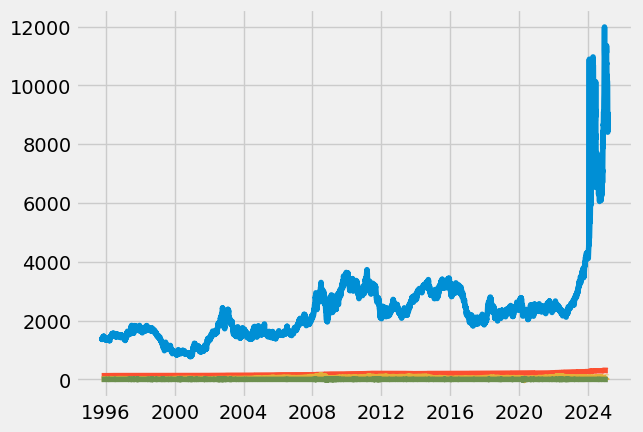

In [309]:
plt.plot(df1);

In [310]:
# following function is taken from: https://youtu.be/q_HS4s1L8UI?si=aTWVN4KqjxnZY6HL

def prepare_dataframe_for_lstm(df, n_steps):
    df = deepcopy(df)
    for i in range(n_steps, 0, -1):
        df[f'icco(t-{i})'] = df['icco_daily_price'].shift(i)
    df.dropna(inplace=True)
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(df1, lookback)
shifted_df

,icco_daily_price,cnft_price,oil_price,sp500_change,icco(t-7),icco(t-6),icco(t-5),icco(t-4),icco(t-3),icco(t-2),icco(t-1)
Date,,,,,,,,,,,
1995-10-12,1378.73,124.100,17.08,0.62,1372.80,1381.55,1375.45,1373.33,1375.14,1358.34,1362.39
1995-10-13,1374.23,124.100,17.38,0.24,1381.55,1375.45,1373.33,1375.14,1358.34,1362.39,1378.73
1995-10-16,1389.96,124.100,17.60,-0.26,1375.45,1373.33,1375.14,1358.34,1362.39,1378.73,1374.23
1995-10-17,1401.67,124.100,17.59,0.65,1373.33,1375.14,1358.34,1362.39,1378.73,1374.23,1389.96
1995-10-18,1386.46,124.100,17.57,0.10,1375.14,1358.34,1362.39,1378.73,1374.23,1389.96,1401.67
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-21,9106.42,298.192,70.72,-1.71,10045.51,10010.22,10337.68,10170.58,10123.90,10050.88,9961.58
2025-02-24,8408.72,298.192,71.06,-0.50,10010.22,10337.68,10170.58,10123.90,10050.88,9961.58,9106.42
2025-02-25,8668.57,298.192,69.15,-0.47,10337.68,10170.58,10123.90,10050.88,9961.58,9106.42,8408.72


In [311]:
shifted_df['year'] = shifted_df.index.year
shifted_df

,icco_daily_price,cnft_price,oil_price,sp500_change,icco(t-7),icco(t-6),icco(t-5),icco(t-4),icco(t-3),icco(t-2),icco(t-1),year
Date,,,,,,,,,,,,
1995-10-12,1378.73,124.100,17.08,0.62,1372.80,1381.55,1375.45,1373.33,1375.14,1358.34,1362.39,1995
1995-10-13,1374.23,124.100,17.38,0.24,1381.55,1375.45,1373.33,1375.14,1358.34,1362.39,1378.73,1995
1995-10-16,1389.96,124.100,17.60,-0.26,1375.45,1373.33,1375.14,1358.34,1362.39,1378.73,1374.23,1995
1995-10-17,1401.67,124.100,17.59,0.65,1373.33,1375.14,1358.34,1362.39,1378.73,1374.23,1389.96,1995
1995-10-18,1386.46,124.100,17.57,0.10,1375.14,1358.34,1362.39,1378.73,1374.23,1389.96,1401.67,1995
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-21,9106.42,298.192,70.72,-1.71,10045.51,10010.22,10337.68,10170.58,10123.90,10050.88,9961.58,2025
2025-02-24,8408.72,298.192,71.06,-0.50,10010.22,10337.68,10170.58,10123.90,10050.88,9961.58,9106.42,2025
2025-02-25,8668.57,298.192,69.15,-0.47,10337.68,10170.58,10123.90,10050.88,9961.58,9106.42,8408.72,2025


In [312]:
df_year = shifted_df["year"].values
y = shifted_df["icco_daily_price"].values
X = shifted_df.drop(["icco_daily_price", "year"], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df_year)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [313]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(5884, 10)
(736, 10)
(736, 10)
(5884,)
(736,)
(736,)


In [314]:
X_train = X_train.reshape((-1, X_train.shape[1], 1))
y_train = y_train.reshape(-1, 1)
X_valid = X_valid.reshape((-1, X_valid.shape[1], 1))
y_valid = y_valid.reshape(-1, 1)
X_test = X_test.reshape((-1, X_test.shape[1], 1))
y_test = y_test.reshape(-1, 1)

In [315]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(5884, 10, 1)
(736, 10, 1)
(736, 10, 1)
(5884, 1)
(736, 1)
(736, 1)


In [316]:
class TS_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = self.X[idx] 
        target = self.y[idx]
        features = torch.tensor(features).float()
        target = torch.tensor(target).float()
        return features, target
        

In [317]:
train_dataset = TS_Dataset(X_train, y_train) 
valid_dataset = TS_Dataset(X_valid, y_valid)
test_dataset = TS_Dataset(X_test, y_test)

In [318]:
print(len(train_dataset))
print(train_dataset[0])
print(len(valid_dataset))
print(valid_dataset[0])
print(len(test_dataset))
print(test_dataset[0])

5884
(tensor([[1.3970e+02],
        [3.7760e+01],
        [8.3000e-01],
        [2.0529e+03],
        [2.0705e+03],
        [2.0614e+03],
        [1.9774e+03],
        [2.0124e+03],
        [2.0429e+03],
        [2.0268e+03]]), tensor([2064.2600]))
736
(tensor([[ 1.9470e+02],
        [ 1.0504e+02],
        [-3.5000e-01],
        [ 3.1472e+03],
        [ 3.1542e+03],
        [ 3.1695e+03],
        [ 3.1754e+03],
        [ 3.1590e+03],
        [ 3.1699e+03],
        [ 3.1727e+03]]), tensor([3201.0500]))
736
(tensor([[1.3220e+02],
        [2.1470e+01],
        [6.2000e-01],
        [1.3359e+03],
        [1.3289e+03],
        [1.3263e+03],
        [1.3506e+03],
        [1.3507e+03],
        [1.3422e+03],
        [1.3349e+03]]), tensor([1416.3900]))


In [319]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [320]:
def fn():
    for X, y in train_loader:
        print(X.shape)
        print(y.shape)
        break

fn()

torch.Size([64, 10, 1])
torch.Size([64, 1])


In [321]:
class Model1(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
        

In [322]:
def fn():
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, 
                              num_workers=2, pin_memory=True)
    model = Model1(1,4,1).to(device)
    for X,y in train_loader:
        X = X.to(device)
        y = y.to(device)
        print(X.shape)
        print(y.shape)
        otpt = model(X)
        print(otpt.shape)
        break
    

fn()

torch.Size([256, 10, 1])
torch.Size([256, 1])
torch.Size([256, 1])


In [323]:
# use this code to free up gpu memory
gc.collect()
torch.cuda.empty_cache()
print("freed up some memory!")

freed up some memory!


In [324]:
torch.cuda.device_count()    # check number of cores in gpu

0

In [325]:
os.cpu_count()    # check number of cores in cpu

4

In [326]:
curr_time = get_current_time()
curr_time

'29_03_2025__03_35_55'

In [327]:
path = os.path.join(os.getcwd(), curr_time)
os.makedirs(path, exist_ok=True)

print(path)

/kaggle/working/29_03_2025__03_35_55


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  1%|          | 1/100 [00:00<01:24,  1.17it/s]

Model info saved!


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  2%|▏         | 2/100 [00:01<01:20,  1.22it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are 

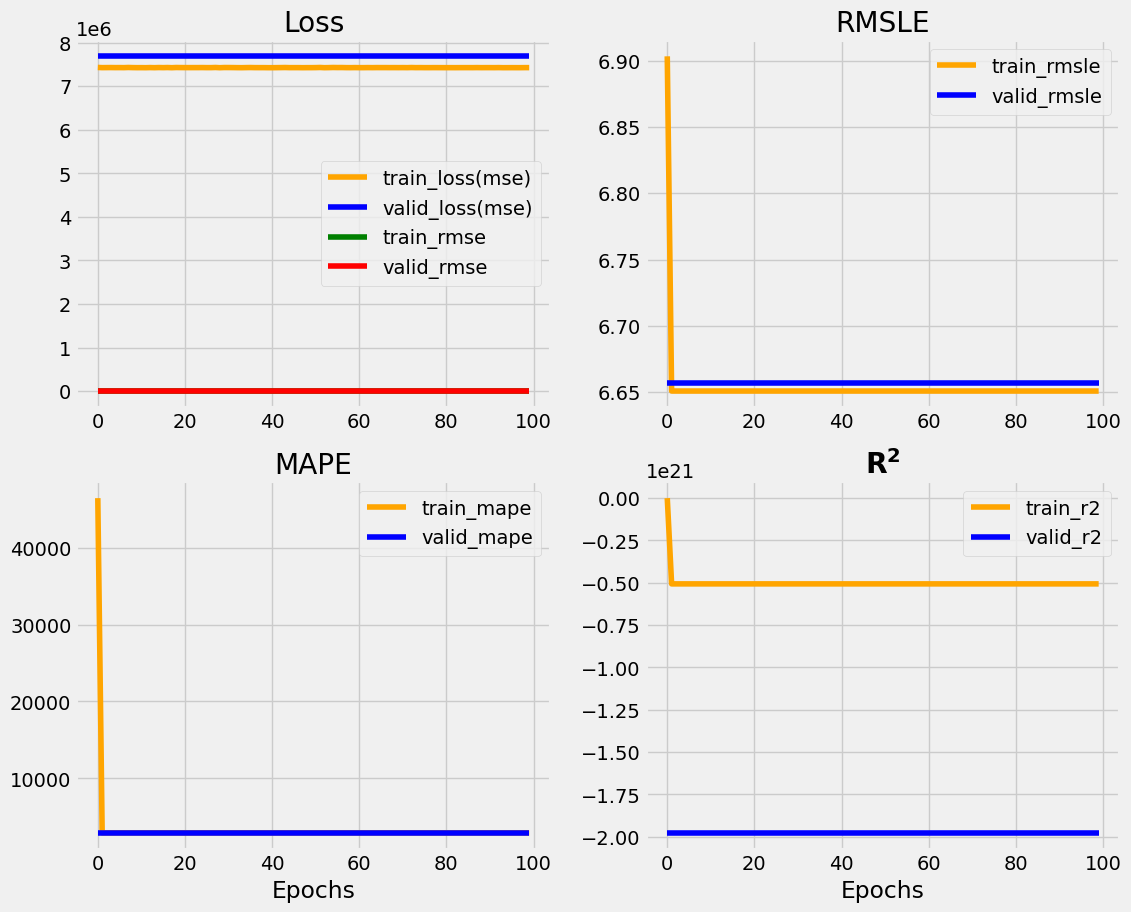

In [328]:
model1 = Model1(1,4,1).to(device)
loss_fn1 = nn.MSELoss()
optimizer1 = optim.AdamW(model1.parameters(), lr=3e-3, weight_decay=1e-4)
scheduler1 = optim.lr_scheduler.StepLR(optimizer1, step_size=7, gamma=0.1)
scaler1 = GradScaler(device)   # for mixed precision training

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

training_fn1(model1, loss_fn1, optimizer1, train_loader, val_loader, device, epochs=100, 
             scheduler=scheduler1, scheduler_on="valid_loss(mse)", verbose=False, scaler=None,
             save_best_model=True, path=path, model_name="Model1.pt", optimizer_name="AdamW1.pt",
             scheduler_name="StepLR1.pt")